In [ ]:
import configparser
import os
import pyproj
import json

from dotenv import load_dotenv
from pathlib import Path
from typing import Literal

import h3
import numpy as np
from shapely import Polygon
from geojson import Feature, FeatureCollection

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

from sklearn.metrics.pairwise import haversine_distances
from math import radians

import torch
import torch.nn as nn
import random
from torchinfo import summary

config = configparser.ConfigParser()
config.read("./src/secrets.conf")

from src.data.dataloader import TrajectoryDataModule
from src.data.schemas import (
    trajectories_schema,
    flight_categories_schema,
    temporal_categories_schema,
    non_seq_numerical_schema,
    training_trajectories_schema,
    training_trajectories_with_latlon_schema,
    training_trajectories_with_xy_schema
)

/usr/local/lib/python3.11/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.11/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


# Experiment Setup

In [4]:
GEODATA_REPRESENTATION : Literal["h3", "xy", "latlon"] = "h3"
H3_RESOLUTION : Literal["5", "6", "7", "8", "9", "10", "11"] = "5"
IN_SEQ_LEN = 5 #Fixed
TGT_SEQ_LEN = 60 #Fixed
SAMPLING_TIME = 60 #Fixed

# Experiment

In [5]:
AIRPORT = "LFBO"
START = "2024-10-1"
END = "2024-11-6"

DATA_SOURCE = Path('./src/data/raw')

MODEL_CKP_PATH = './src/models/checkpoints'
BATCH_SIZE = 64

MAX_LAT = 90.               # degrees
MAX_LON = 180.              # degrees
MAX_ALTITUDE = 43100        # ft
MAX_SPEED = 600             # knots
MAX_TRACK = 360             # degrees
MAX_RATE = 3000             # ft./min

MIN_LAT = -90.
MIN_LON = -180.
MIN_ALTITUDE = 0.0
MIN_RATE = -MAX_RATE
MIN_SPEED = 0.0
MIN_TRACK = 0.0
EARTH_RADIUS_M = 6378000

TRAJECTORY_COLUMNS = list(trajectories_schema.keys())
CATEGORY_COLUMNS = list(flight_categories_schema.keys())
WEATHER_COLUMNS = list(non_seq_numerical_schema.keys())
TEMPORAL_COLUMNS = list(temporal_categories_schema.keys())

if GEODATA_REPRESENTATION == "latlon":
    TRAINING_COLUMNS = list(training_trajectories_with_latlon_schema.keys())
elif GEODATA_REPRESENTATION == "xy":
    TRAINING_COLUMNS = list(training_trajectories_with_xy_schema.keys())
else: # Default use h3
    TRAINING_COLUMNS = list(training_trajectories_schema.keys())
TRAINING_COLUMNS


['h3_cell', 'altitude', 'diff_time']

In [6]:
def gps_to_ecef(lat, lon, alt):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

    x, y, z = pyproj.transform(lla, ecef, lon, lat, alt, radians=False)
    return pd.Series([x, y, z])

def ecef_to_gps(x, y, z):
    ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
    lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')

    lon, lat, h = pyproj.transform(ecef, lla, x, y, z, radians=False)
    return lat, lon, h

def get_geo_distance(
        origin: tuple[float, float],
        destination: tuple[float, float],
        unit: Literal["km", "m"] = "km",
    ) -> float:

    origin_in_radians = [radians(deg_coord) for deg_coord in origin]
    destination_in_radians = [radians(deg_coord) for deg_coord in destination]
    result = haversine_distances([origin_in_radians, destination_in_radians])
    result = result[np.where(result != 0.)]
    if not isinstance(result, float):
        if len(result) == 0:
            result = 0.0
        else:
            result = result[0]
    if unit == "km":
        return result * EARTH_RADIUS_M / 1000
    return result * EARTH_RADIUS_M

In [7]:
def h3_to_polygon(cell):
    coords = h3.cell_to_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

def hexagons_dataframe_to_geojson(df_hex, hex_id_field, geometry_field, value_field, file_output = None):
    list_features = []
    for i, row in df_hex.iterrows():
        feature = Feature(
            geometry = row[geometry_field],
            id = row[hex_id_field],
            properties = {"value": row[value_field]},
        )
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    if file_output is not None:
        with open(file_output, "w") as f:
            json.dump(feat_collection, f)
    else :
      return feat_collection

def get_geojson_df(df, id_column="flight_id", h3_cell_column="h3_cell"):
    df["h3_geometry"] = df[h3_cell_column].apply(lambda x: h3_to_polygon(x))

    g_df = (
        df[[id_column, h3_cell_column, "h3_geometry"]]
        .groupby(h3_cell_column)
        .agg({id_column: set, "h3_geometry": "first"})
        .reset_index()
    )
    g_df["num_flights"] = g_df[id_column].apply(lambda row: len(row))


    return g_df, hexagons_dataframe_to_geojson(
        g_df,
        h3_cell_column,
        "h3_geometry",
        "num_flights"
    )

In [8]:
data_module = TrajectoryDataModule(
    dataset_kwargs={
        "airport": AIRPORT,
        "start": START,
        "end": END,
        "input_len": IN_SEQ_LEN,
        "target_len": TGT_SEQ_LEN,
        "data_source": DATA_SOURCE,
        "sampling_time": SAMPLING_TIME,
        "h3_resolution": H3_RESOLUTION,
        "training_columns": TRAINING_COLUMNS,
    },
    batch_size=BATCH_SIZE,
)

[{'year': 2024, 'month': 10, 'day': 1}, {'year': 2024, 'month': 10, 'day': 2}, {'year': 2024, 'month': 10, 'day': 3}, {'year': 2024, 'month': 10, 'day': 4}, {'year': 2024, 'month': 10, 'day': 5}, {'year': 2024, 'month': 10, 'day': 6}, {'year': 2024, 'month': 10, 'day': 7}, {'year': 2024, 'month': 10, 'day': 8}, {'year': 2024, 'month': 10, 'day': 9}, {'year': 2024, 'month': 10, 'day': 10}, {'year': 2024, 'month': 10, 'day': 11}, {'year': 2024, 'month': 10, 'day': 12}, {'year': 2024, 'month': 10, 'day': 13}, {'year': 2024, 'month': 10, 'day': 14}, {'year': 2024, 'month': 10, 'day': 15}, {'year': 2024, 'month': 10, 'day': 16}, {'year': 2024, 'month': 10, 'day': 17}, {'year': 2024, 'month': 10, 'day': 18}, {'year': 2024, 'month': 10, 'day': 19}, {'year': 2024, 'month': 10, 'day': 20}, {'year': 2024, 'month': 10, 'day': 21}, {'year': 2024, 'month': 10, 'day': 22}, {'year': 2024, 'month': 10, 'day': 23}, {'year': 2024, 'month': 10, 'day': 24}, {'year': 2024, 'month': 10, 'day': 25}, {'year':

/content/drive/MyDrive/TUM/Masters Thesis/codes/4d_trajectory_prediction/src/data/dataset.py:327: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("altitude").map_elements(lambda x: ...)
with this one instead:
  + pl.col("altitude") * 0.3048

  pl.col("altitude").map_elements(lambda x: x * 0.3048).alias("altitude"),
/content/drive/MyDrive/TUM/Masters Thesis/codes/4d_trajectory_prediction/src/data/dataset.py:328: PolarsInefficientMapWarning: 
Expr.map_elements is significantly slower than the native expressions API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - pl.col("gps_altitude").map_elements(lambda x: ...)
with this one instead:
  + pl.col("gps_altitude") * 0.3048

  pl.col("gps_altitude").map_elements(lambda x: x * 0.3048).alias("gps_altitude")
sys:1: MapWithoutReturnDtypeW

In [9]:
train_flight_ids = []
for _,_,ids,_ in data_module.train_dataloader():
    train_flight_ids.extend(ids)

val_flight_ids = []
for _,_,ids,_ in data_module.val_dataloader():
    val_flight_ids.extend(ids)

test_flight_ids = []
for _,tgt,ids,_ in data_module.test_dataloader():
    test_flight_ids.extend(ids)

In [10]:
df = data_module.data.data.to_pandas()

In [11]:
data_train = df.loc[df.flight_id.isin(train_flight_ids)]
data_train["type"] = "train"

data_val = df.loc[df.flight_id.isin(val_flight_ids)]
data_val["type"] = "val"

data_test = df.loc[df.flight_id.isin(test_flight_ids)]
data_test["type"] = "test"

data = pd.concat([data_train, data_val, data_test])

g_df, geojson_obj = get_geojson_df(data)

h3_traj = px.choropleth_mapbox(
    data,
    geojson=geojson_obj,
    locations="h3_cell",
    color="type",
    zoom=0,
    opacity=0.3,
)

geo_traj = px.scatter_mapbox(
    data,
    lat="latitude",
    lon="longitude",
    hover_data=["flight_id", "timestamp"],
    color="type",
    zoom=0
)

fig = go.Figure(h3_traj)
fig.add_traces(list(geo_traj.select_traces()))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(title="Flights paths", mapbox_style="open-street-map")
fig.write_html("./plots/train_val_test_paths.html")

<ipython-input-11-86a6b0984601>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train["type"] = "train"
<ipython-input-11-86a6b0984601>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val["type"] = "val"
<ipython-input-11-86a6b0984601>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [12]:
if "latitude" in TRAINING_COLUMNS:
  EXPERIMENT_NAME = f"latlon_{SAMPLING_TIME}_{IN_SEQ_LEN}_{TGT_SEQ_LEN}"
  VOCABS_SIZES =[
        len(data_module.data.vocabs["latitude"]),
        len(data_module.data.vocabs["longitude"]),
        len(data_module.data.vocabs["altitude"]),
        len(data_module.data.vocabs["diff_time"])
    ]
elif "x" in TRAINING_COLUMNS:
  EXPERIMENT_NAME = f"xy_{SAMPLING_TIME}_{IN_SEQ_LEN}_{TGT_SEQ_LEN}"
  VOCABS_SIZES =[
        len(data_module.data.vocabs["x"]),
        len(data_module.data.vocabs["y"]),
        len(data_module.data.vocabs["altitude"]),
        len(data_module.data.vocabs["diff_time"])
    ]
else:
  EXPERIMENT_NAME = f"h3_{SAMPLING_TIME}_{H3_RESOLUTION}_{IN_SEQ_LEN}_{TGT_SEQ_LEN}"
  VOCABS_SIZES =[
        len(data_module.data.vocabs["h3_cell"]),
        len(data_module.data.vocabs["altitude"]),
        len(data_module.data.vocabs["diff_time"])
    ]
EXPERIMENT_NAME

'h3_60_5_5_60'

In [13]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float(np.inf)

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [14]:
class TrajectoryPredictor(nn.Module):
    def __init__(
            self,
            embed_size,
            hidden_size,
            vocabs_sizes,
            dropout_p=0.2,
            output_features=4,
            tgt_seq_len=TGT_SEQ_LEN,
            num_enc_layers = 1,
            num_dec_layers = 2,
        ):
        super(TrajectoryPredictor, self).__init__()
        self.embed_size = embed_size
        self.vocabs_sizes = vocabs_sizes
        self.tgt_seq_len = tgt_seq_len
        self.output_features = output_features
        self.hidden_size = hidden_size
        self.num_enc_layers = num_enc_layers
        self.num_dec_layers = num_dec_layers

        self.embed_1 = nn.Embedding(num_embeddings=self.vocabs_sizes[0], embedding_dim=self.embed_size)
        self.embed_2 = nn.Embedding(num_embeddings=self.vocabs_sizes[1], embedding_dim=self.embed_size)
        self.embed_3 = nn.Embedding(num_embeddings=self.vocabs_sizes[2], embedding_dim=self.embed_size)

        self.layernorm_1 = nn.LayerNorm(normalized_shape=self.embed_size)
        self.layernorm_2 = nn.LayerNorm(normalized_shape=self.hidden_size)
        self.layernorm_3 = nn.LayerNorm(normalized_shape=self.vocabs_sizes[0])
        self.layernorm_4 = nn.LayerNorm(normalized_shape=self.vocabs_sizes[1])
        self.layernorm_5 = nn.LayerNorm(normalized_shape=self.vocabs_sizes[2])

        self.lstm_enc = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, num_layers=self.num_enc_layers )
        self.lstm_dec = nn.LSTM(input_size=self.embed_size, hidden_size=self.hidden_size, num_layers=self.num_dec_layers)

        self.dense_1 = nn.Linear(in_features=self.hidden_size, out_features=self.vocabs_sizes[0])
        self.dense_2 = nn.Linear(in_features=self.hidden_size, out_features=self.vocabs_sizes[1])
        self.dense_3 = nn.Linear(in_features=self.hidden_size, out_features=self.vocabs_sizes[2])

        if len(self.vocabs_sizes) > 3:
          self.embed_4 = nn.Embedding(num_embeddings=self.vocabs_sizes[3], embedding_dim=self.embed_size)
          self.layernorm_6 = nn.LayerNorm(normalized_shape=self.vocabs_sizes[3])
          self.dense_4 = nn.Linear(in_features=self.hidden_size, out_features=self.vocabs_sizes[3])

        self.dropout = nn.Dropout(dropout_p)
        self.log_softmax = nn.LogSoftmax(dim=2)


    def forward(
            self,
            x_1,
            y_1,
            x_2=None,
            y_2=None,
            x_3=None,
            y_3=None,
            x_4=None,
            y_4=None,

        ):
        x = self.embed_1(x_1.to(torch.int32))
        if x_2 is not None:
            x_2 = self.embed_2(x_2.to(torch.int32))
            x = torch.cat((x, x_2), dim=0)
        if x_3 is not None:
            x_3 = self.embed_3(x_3.to(torch.int32))
            x = torch.cat((x, x_3), dim=0)
        if x_4 is not None:
            x_4 = self.embed_4(x_4.to(torch.int32))
            x = torch.cat((x, x_4), dim=0)
        x = x.squeeze(dim=1)
        x = self.layernorm_1(x)

        x, encoder_state = self.lstm_enc(x)

        y = self.embed_1(y_1.to(torch.int32))
        if y_2 is not None:
            y_2 = self.embed_2(y_2.to(torch.int32))
            y = torch.cat((y, y_2), dim=0)
        if y_3 is not None:
            y_3 = self.embed_3(y_3.to(torch.int32))
            y = torch.cat((y, y_3), dim=0)
        if y_4 is not None:
            y_4 = self.embed_4(y_4.to(torch.int32))
            y = torch.cat((y, y_4), dim=0)
        y = y.squeeze(dim=1)
        y = self.layernorm_1(y)

        y, _ = self.lstm_dec(
            y,
            (
                encoder_state[0].repeat(self.num_dec_layers, 1, 1),
                encoder_state[1].repeat(self.num_dec_layers, 1, 1)
            )
        )
        y = self.layernorm_2(y)

        if y_2 is None and y_3 is None:
            y_hat_1 = y
            y_hat_2 = None
            y_hat_3 = None
            y_hat_4 = None
        else:
            if y_3 is None:
                y_hat_1, y_hat_2 = torch.split(y, [y_1.size(0), y_2.size(0)], dim=0)
                y_hat_3 = None
                y_hat_4 = None
            else:
                if y_4 is not None:
                    y_hat_1, y_hat_2, y_hat_3, y_hat_4 = torch.split(
                        y,
                        [y_1.size(0), y_2.size(0), y_3.size(0), y_4.size(0)],
                        dim=0
                    )
                    y_hat_4 = self.dropout(self.dense_4(y_hat_4))
                    y_hat_4 = self.log_softmax(self.layernorm_6(y_hat_4))
                    y_hat_4 = torch.permute(y_hat_4, (1,2,0))
                    if y_hat_4.size(2) > self.tgt_seq_len:
                        y_hat_4 = y_hat_4[:, :, :-2]
                else:
                    y_hat_4 = None
                    y_hat_1, y_hat_2, y_hat_3 = torch.split(
                        y,
                        [y_1.size(0), y_2.size(0), y_3.size(0)],
                        dim=0
                    )

                y_hat_3 = self.dropout(self.dense_3(y_hat_3))
                y_hat_3 = self.log_softmax(self.layernorm_5(y_hat_3))
                y_hat_3 = torch.permute(y_hat_3, (1,2,0))
                if y_hat_3.size(2) > self.tgt_seq_len:
                    y_hat_3 = y_hat_3[:, :, :-2]

            y_hat_2 = self.dropout(self.dense_2(y_hat_2))
            y_hat_2 = self.log_softmax(self.layernorm_4(y_hat_2))
            y_hat_2 = torch.permute(y_hat_2, (1,2,0))
            if y_hat_2.size(2) > self.tgt_seq_len:
                y_hat_2 = y_hat_2[:, :, :-2]

        y_hat_1 = self.dense_1(y_hat_1)
        y_hat_1 = self.dropout(y_hat_1)
        y_hat_1 = self.layernorm_3(y_hat_1)
        y_hat_1 = self.log_softmax(y_hat_1)
        y_hat_1 = torch.permute(y_hat_1, (1,2,0))
        if y_hat_1.size(2) > self.tgt_seq_len:
            y_hat_1 = y_hat_1[:, :, :-2]
        return y_hat_1, y_hat_2, y_hat_3, y_hat_4


In [15]:
EPOCHS = 100
NUM_OUT_DIM = len(TRAINING_COLUMNS)

def train_model(model, data, optimizer, criterion, device):
    model.train()
    total_loss = 0
    dataloader = data.train_dataloader()
    for traj_in, traj_out, _, _ in dataloader:
        traj_in, traj_out = traj_in.to(device), traj_out.to(device)

        if NUM_OUT_DIM == 4:
            x_1, x_2, x_3, x_4 = torch.split(traj_in, [1, 1, 1, 1], dim=1)
            y_1, y_2, y_3, y_4 = torch.split(traj_out, [1, 1, 1, 1], dim=1)

            y_1_logits, y_2_logits, y_3_logits, y_4_logits = model(
                x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4
            )

            y_1 = torch.permute(y_1.squeeze(dim=1), (1,0))
            y_2 = torch.permute(y_2.squeeze(dim=1), (1,0))
            y_3 = torch.permute(y_3.squeeze(dim=1), (1,0))
            y_4 = torch.permute(y_4.squeeze(dim=1), (1,0))

            loss_1 = criterion(y_1_logits, y_1[:, 1:-1])
            loss_2 = criterion(y_2_logits, y_2[:, 1:-1])
            loss_3 = criterion(y_3_logits, y_3[:, 1:-1])
            loss_4 = criterion(y_4_logits, y_4[:, 1:-1])
            loss = (1 / 4) * loss_1 + (1 / 4) * loss_2 + (1 / 4) * loss_3 + (1 / 4) * loss_4
        else:
            x_1, x_2, x_3 = torch.split(traj_in, [1, 1, 1], dim=1)
            y_1, y_2, y_3 = torch.split(traj_out, [1, 1, 1], dim=1)

            y_1_logits, y_2_logits, y_3_logits, _ = model(
                x_1, y_1, x_2, y_2, x_3, y_3
            )

            y_1 = torch.permute(y_1.squeeze(dim=1), (1,0))
            y_2 = torch.permute(y_2.squeeze(dim=1), (1,0))
            y_3 = torch.permute(y_3.squeeze(dim=1), (1,0))

            loss_1 = criterion(y_1_logits, y_1[:, 1:-1])
            loss_2 = criterion(y_2_logits, y_2[:, 1:-1])
            loss_3 = criterion(y_3_logits, y_3[:, 1:-1])
            loss = (1 / 3) * loss_1 + (1 / 3) * loss_2 + (1 / 3) * loss_3

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate_model(model, data, criterion, device):
    model.eval()
    total_loss = 0
    dataloader = data.val_dataloader()
    with torch.no_grad():
        for traj_in, traj_out, _, _ in dataloader:
            traj_in, traj_out = traj_in.to(device), traj_out.to(device)

            if NUM_OUT_DIM == 4:
                x_1, x_2, x_3, x_4 = torch.split(traj_in, [1, 1, 1, 1], dim=1)
                y_1, y_2, y_3, y_4 = torch.split(traj_out, [1, 1, 1, 1], dim=1)

                y_1_logits, y_2_logits, y_3_logits, y_4_logits = model(
                    x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4
                )

                y_1 = torch.permute(y_1.squeeze(dim=1), (1,0))
                y_2 = torch.permute(y_2.squeeze(dim=1), (1,0))
                y_3 = torch.permute(y_3.squeeze(dim=1), (1,0))
                y_4 = torch.permute(y_4.squeeze(dim=1), (1,0))

                loss_1 = criterion(y_1_logits, y_1[:, 1:-1])
                loss_2 = criterion(y_2_logits, y_2[:, 1:-1])
                loss_3 = criterion(y_3_logits, y_3[:, 1:-1])
                loss_4 = criterion(y_4_logits, y_4[:, 1:-1])
                loss = (1 / 4) * loss_1 + (1 / 4) * loss_2 + (1 / 4) * loss_3 + (1 / 4) * loss_4
            else:
                x_1, x_2, x_3 = torch.split(traj_in, [1, 1, 1], dim=1)
                y_1, y_2, y_3 = torch.split(traj_out, [1, 1, 1], dim=1)

                y_1_logits, y_2_logits, y_3_logits, _ = model(
                    x_1, y_1, x_2, y_2, x_3, y_3
                )

                y_1 = torch.permute(y_1.squeeze(dim=1), (1,0))
                y_2 = torch.permute(y_2.squeeze(dim=1), (1,0))
                y_3 = torch.permute(y_3.squeeze(dim=1), (1,0))

                loss_1 = criterion(y_1_logits, y_1[:, 1:-1])
                loss_2 = criterion(y_2_logits, y_2[:, 1:-1])
                loss_3 = criterion(y_3_logits, y_3[:, 1:-1])
                loss = (1 / 3) * loss_1 + (1 / 3) * loss_2 + (1 / 3) * loss_3

            total_loss += loss.item()

    return total_loss / len(dataloader)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stopper = EarlyStopper(patience=3, min_delta=1)

model = TrajectoryPredictor(
    embed_size=128,
    hidden_size=1024,
    dropout_p=0.2,
    vocabs_sizes=VOCABS_SIZES
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.NLLLoss()

summary(model)

Layer (type:depth-idx)                   Param #
TrajectoryPredictor                      --
├─Embedding: 1-1                         1,254,016
├─Embedding: 1-2                         284,544
├─Embedding: 1-3                         61,056
├─LayerNorm: 1-4                         256
├─LayerNorm: 1-5                         2,048
├─LayerNorm: 1-6                         19,594
├─LayerNorm: 1-7                         4,446
├─LayerNorm: 1-8                         954
├─LSTM: 1-9                              4,726,784
├─LSTM: 1-10                             13,123,584
├─Linear: 1-11                           10,041,925
├─Linear: 1-12                           2,278,575
├─Linear: 1-13                           488,925
├─Dropout: 1-14                          --
├─LogSoftmax: 1-15                       --
Total params: 32,286,707
Trainable params: 32,286,707
Non-trainable params: 0

In [19]:
for epoch in range(EPOCHS):
    train_loss = train_model(model, data_module, optimizer, criterion, device)
    val_loss = validate_model(model, data_module, criterion, device)
    if early_stopper.early_stop(val_loss):
        break
    print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1/100, Train Loss: 6.1666, Val Loss: 4.4415
Epoch 2/100, Train Loss: 4.7349, Val Loss: 3.8076
Epoch 3/100, Train Loss: 4.3640, Val Loss: 3.4039
Epoch 4/100, Train Loss: 3.9596, Val Loss: 2.7374
Epoch 5/100, Train Loss: 3.4948, Val Loss: 2.5190
Epoch 6/100, Train Loss: 3.3857, Val Loss: 2.4454
Epoch 7/100, Train Loss: 3.2460, Val Loss: 2.2178
Epoch 8/100, Train Loss: 3.1318, Val Loss: 2.1255
Epoch 9/100, Train Loss: 3.0111, Val Loss: 2.1049
Epoch 10/100, Train Loss: 2.9937, Val Loss: 2.1367
Epoch 11/100, Train Loss: 2.9468, Val Loss: 2.0952
Epoch 12/100, Train Loss: 2.9081, Val Loss: 2.0685
Epoch 13/100, Train Loss: 2.8546, Val Loss: 2.0727
Epoch 14/100, Train Loss: 2.8313, Val Loss: 1.9441
Epoch 15/100, Train Loss: 2.7425, Val Loss: 1.9132
Epoch 16/100, Train Loss: 2.7151, Val Loss: 1.9697
Epoch 17/100, Train Loss: 2.7619, Val Loss: 1.9247
Epoch 18/100, Train Loss: 2.6626, Val Loss: 1.8813
Epoch 19/100, Train Loss: 2.6164, Val Loss: 1.8268
Epoch 20/100, Train Loss: 2.5949, Val Lo

In [20]:
CHECKPOINT_PATH = f"{MODEL_CKP_PATH}/lstm_autoenc_{EXPERIMENT_NAME}.pt"
torch.save(model.state_dict(), CHECKPOINT_PATH)
print(f'Model saved at: {CHECKPOINT_PATH}')

Model saved at: ./src/models/checkpoints/lstm_autoenc_h3_60_5_5_60.pt


In [21]:
import torch
import torch.nn as nn
import numpy as np

import numpy as np


def h3_to_x_y(h3_cell: str, alt:float=0.0):
    try:
        lat, lon = h3.cell_to_latlng(h3_cell)
    except:
        lat, lon = np.nan, np.nan
    return np.array([lat, lon])

def plot_pred_vs_true(pred, true, y_label, title, x_label=f'Timestep (in {SAMPLING_TIME})'):
    """Plot predicted vs true trajectories."""
    plt.figure(figsize=(10, 6))
    plt.plot(true, label='True Value', marker='o')
    plt.plot(pred, label='Predicted Value', marker='x')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.title(title)
    plt.show()

def compute_spatial_errors(predictions, ground_truth, transform_data = None, true_z_coord=None):
    """Compute MAE, RMSE, ADE, and FDE for 3D trajectory predictions."""
    if transform_data == "ecef_2_geo":
        #x,y,z to lat,lon,h
        pred_1, pred_2, _ = ecef_to_gps(
            predictions[..., 0], predictions[..., 1], true_z_coord
        )
        gt_1, gt_2, _ = ecef_to_gps(
            ground_truth[..., 0], ground_truth[..., 1], true_z_coord
        )
        predictions = np.stack((pred_1, pred_2, predictions[..., 2]), axis=-1)
        ground_truth = np.stack((gt_1, gt_2, ground_truth[..., 2]), axis=-1)
    elif transform_data == "geo_2_ecef":
        #lat,lon,h to x,y,z
        pred_1, pred_2, _ = gps_to_ecef(
            predictions[..., 0], predictions[..., 1], true_z_coord
        )
        gt_1, gt_2, _ = gps_to_ecef(
            ground_truth[..., 0], ground_truth[..., 1], ground_truth[..., 2]
        )
        predictions = np.stack((pred_1, pred_2, predictions[..., 2]), axis=-1)
        ground_truth = np.stack((gt_1, gt_2, ground_truth[..., 2]), axis=-1)


    # Compute errors
    errors = np.abs(predictions - ground_truth)
    squared_errors = errors ** 2

    # Per feature dimension
    mae = np.mean(errors, axis=(0, 1))
    rmse = np.sqrt(np.mean(squared_errors, axis=(0, 1)))

    # ADE (Average Displacement Error)
    displacement_errors = np.linalg.norm(predictions - ground_truth, axis=-1)
    ade = np.mean(displacement_errors)

    # FDE (Final Displacement Error)
    final_displacement_errors = np.linalg.norm(
        predictions[:, -1, :] - ground_truth[:, -1, :], axis=-1
    )
    fde = np.mean(final_displacement_errors)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "ADE": ade,
        "FDE": fde,
    }, predictions, ground_truth


def evaluate_model(model, data, device):
    model.eval()
    dataloader = data.test_dataloader()
    all_predictions = []
    all_targets = []
    all_flight_ids = []
    all_distance_errors = []
    all_spatial_true_values = []
    scaled_columns = ["latitude", "longitude", "altitude", "x", "y"]
    with torch.no_grad():
        for traj_in, traj_out, ids, true in dataloader:
            all_flight_ids.append(np.repeat(np.array(ids), TGT_SEQ_LEN))
            traj_in, traj_out = traj_in.to(device), traj_out.to(device)

            true_x, true_y, true_z, true_lat, true_lon, true_gps_alt = torch.split(true, [1, 1, 1, 1, 1, 1], dim=1)
            true_x = torch.permute(true_x, (2, 1, 0))
            true_y = torch.permute(true_y, (2, 1, 0))
            true_z = torch.permute(true_z, (2, 1, 0))
            true_lat = torch.permute(true_lat, (2, 1, 0))
            true_lon = torch.permute(true_lon, (2, 1, 0))
            true_gps_alt = torch.permute(true_gps_alt, (2, 1, 0))
            true_spatial_data = torch.cat([true_x, true_y, true_z, true_lat, true_lon, true_gps_alt], dim=1).detach().cpu().numpy()[:, :, :] #(N, out_dim, SEQ_LEN)
            all_spatial_true_values.append(true_spatial_data)

            if NUM_OUT_DIM == 4:
                  x_1, x_2, x_3, x_4 = torch.split(traj_in, [1, 1, 1, 1], dim=1)
                  tgt_y_1, tgt_y_2, tgt_y_3, tgt_y_4 = torch.split(traj_out, [1, 1, 1, 1], dim=1)

                  tgt_y_1 = torch.permute(tgt_y_1, (2, 1, 0))
                  tgt_y_2 = torch.permute(tgt_y_2, (2, 1, 0))
                  tgt_y_3 = torch.permute(tgt_y_3, (2, 1, 0))
                  tgt_y_4 = torch.permute(tgt_y_4, (2, 1, 0))
                  targets = torch.cat([tgt_y_1, tgt_y_2, tgt_y_3, tgt_y_4], dim=1).detach().cpu().numpy()[:, : , 1:-1] #(N, out_dim, SEQ_LEN
            else:
                x_4 = None
                tgt_y_4 = None
                x_1, x_2, x_3 = torch.split(traj_in, [1, 1, 1], dim=1)
                tgt_y_1, tgt_y_2, tgt_y_3 = torch.split(traj_out, [1, 1, 1], dim=1)

                tgt_y_1 = torch.permute(tgt_y_1, (2, 1, 0))
                tgt_y_2 = torch.permute(tgt_y_2, (2, 1, 0))
                tgt_y_3 = torch.permute(tgt_y_3, (2, 1, 0))
                targets = torch.cat([tgt_y_1, tgt_y_2, tgt_y_3], dim=1).detach().cpu().numpy()[:, :, 1:-1] #(N, out_dim, SEQ_LEN)


            y_1, y_2, y_3, y_4 = None, None, None, None
            predictions = []
            real_values = []
            bs = tgt_y_1.size(0)
            for j, feature in enumerate(TRAINING_COLUMNS):
                end_token = torch.tensor([data.data.vocabs[feature].lookup_indices(["END"])], dtype=torch.long).unsqueeze(dim=1).repeat(1,1,bs).to(device)
                start_token = torch.tensor([data.data.vocabs[feature].lookup_indices(["START"])], dtype=torch.long).unsqueeze(dim=1).repeat(1,1,bs).to(device)
                if feature in ["h3_cell", "x", "latitude"]:
                    y_1 = start_token
                preds = []
                tgts = []
                grid_center_preds = []
                grid_center_targets = []
                for i in range(TGT_SEQ_LEN):
                    y_1_logits, y_2_logits, y_3_logits, y_4_logits = model(
                        x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4
                    )
                    target = targets[:, j, i]
                    tgt = target.flatten().tolist()
                    tgt = np.array(data.data.vocabs[feature].lookup_tokens(tgt))

                    if feature in ["h3_cell", "x", "latitude"]:
                        logits = y_1_logits
                    elif (feature in ["y", "longitude"]) or (feature == "altitude" and "h3_cell" in TRAINING_COLUMNS):
                        logits = y_2_logits
                    elif (feature == "altitude") or ("h3_cell" in TRAINING_COLUMNS):
                        logits = y_3_logits
                    else:
                        logits = y_4_logits

                    pred = torch.argmax(logits[:,:,i], dim=1)
                    if feature in ["h3_cell", "x", "latitude"]:
                        y_1 = torch.cat([y_1,  pred.unsqueeze(dim=0).unsqueeze(dim=1)], dim=0)
                        if i == TGT_SEQ_LEN - 1:
                            y_1 = torch.cat([y_1,  end_token], dim=0)
                            y_2 = start_token
                    elif (feature in ["y", "longitude"]) or (feature == "altitude" and "h3_cell" in TRAINING_COLUMNS):
                        y_2 = torch.cat([y_2,  pred.unsqueeze(dim=0).unsqueeze(dim=1)], dim=0)
                        if i == TGT_SEQ_LEN - 1:
                            y_2 = torch.cat([y_2,  end_token], dim=0)
                            y_3 = start_token
                    elif (feature == "altitude") or ("h3_cell" in TRAINING_COLUMNS):
                        y_3 = torch.cat([y_3,  pred.unsqueeze(dim=0).unsqueeze(dim=1)], dim=0)
                        if i == TGT_SEQ_LEN - 1:
                            y_3 = torch.cat([y_3,  end_token], dim=0)
                            y_4 = start_token
                    else:
                        y_4 = torch.cat([y_4,  pred.unsqueeze(dim=0).unsqueeze(dim=1)], dim=0)
                        if i == TGT_SEQ_LEN - 1:
                            y_4 = torch.cat([y_4,  end_token], dim=0)

                    pred = pred.detach().cpu().numpy().flatten().tolist()
                    pred = np.array(data.data.vocabs[feature].lookup_tokens(pred))
                    pred[pred == "START"] = None
                    pred[pred == "END"] = None

                    if feature == "time_diff" or feature in scaled_columns:
                        pred = pred.astype(float)
                        tgt = tgt.astype(float)
                    if feature in scaled_columns:
                        k = scaled_columns.index(feature)
                        pred = np.squeeze(data.data._reverse_scale_data(pred, k), axis=-1)
                        tgt = np.squeeze(data.data._reverse_scale_data(tgt, k), axis=-1)

                    preds.append(pred)
                    tgts.append(tgt)

                    if feature == "h3_cell":
                        pred_coordinates = [
                            np.array(h3_to_x_y(h3_cell)) if h3_cell is not None else [None,None,None] for h3_cell in pred
                        ]
                        grid_center_preds.append(np.array(pred_coordinates))

                        tgt_coordinates = [
                            np.array(h3_to_x_y(h3_cell)) for h3_cell in tgt
                        ]
                        grid_center_targets.append(np.array(tgt_coordinates))

                predictions.append(np.stack(preds)[..., np.newaxis])
                real_values.append(np.stack(tgts)[..., np.newaxis])
                if feature == "h3_cell":
                    predictions.append(np.stack(grid_center_preds))
                    real_values.append(np.stack(grid_center_targets))

            all_predictions.append(np.concatenate(predictions, axis=2))
            all_targets.append(np.concatenate(real_values, axis=2))

    all_predictions = np.concatenate(all_predictions, axis=1)
    all_targets = np.concatenate(all_targets, axis=1)
    all_flight_ids = np.concatenate(all_flight_ids)
    all_spatial_true_values = np.concatenate(all_spatial_true_values, axis=0)

    all_predictions = np.moveaxis(all_predictions, [0, 1], [1, 0])
    all_targets = np.moveaxis(all_targets, [0, 1], [1, 0])
    all_spatial_true_values = np.moveaxis(all_spatial_true_values, [0, 1, 2], [0, 2, 1])
    return all_predictions, all_targets, all_flight_ids, all_spatial_true_values

In [22]:
predictions, targets, flight_ids, spatial_true_values = evaluate_model(model, data_module, device=device)
print(predictions.shape, targets.shape, flight_ids.shape, spatial_true_values.shape)

(124, 60, 5) (124, 60, 5) (7440,) (124, 60, 6)


Sample Flight ID: VOE9AZ_009_2024_10_20

Temporal Errors:
MAE: 2.903225806451613
RMSE: 15.24001524002286
ADE: 22.488290397333387
FDE: 169.7056274847714
----------------------------
Spatial Errors Geo:
MAE per dimension: [   2.44189578    4.71509763 1422.87873687]
RMSE per dimension: [   3.76947447   10.91349998 2389.62807562]
ADE: 1423.034942899118
FDE: 3945.413442310091

----------------------------
Spatial Errors ECEF:
MAE per dimension: [229328.3751882  346901.12746887   1422.87873687]
RMSE per dimension: [453544.37243385 708433.43989285   2389.62807562]
ADE: 437704.9731828615
FDE: 218513.71540631377



<ipython-input-6-5bede1129493>:5: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1

<ipython-input-6-5bede1129493>:5: FutureWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



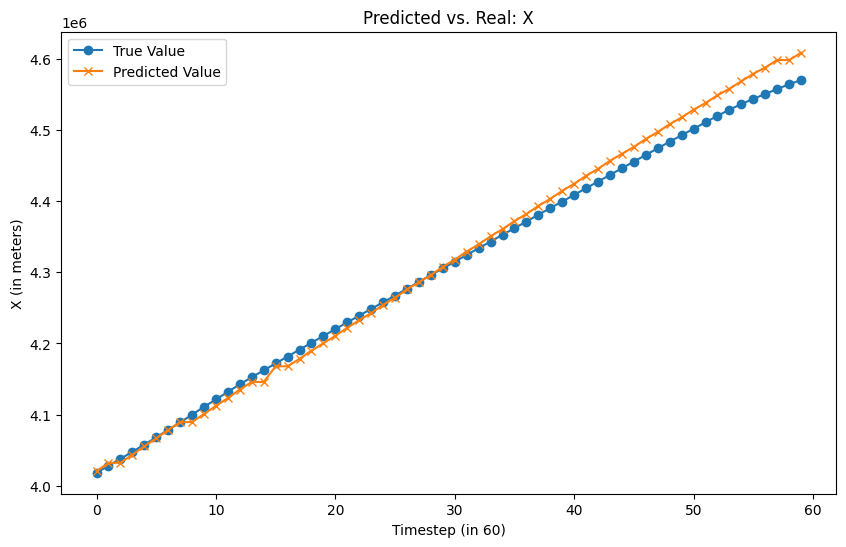

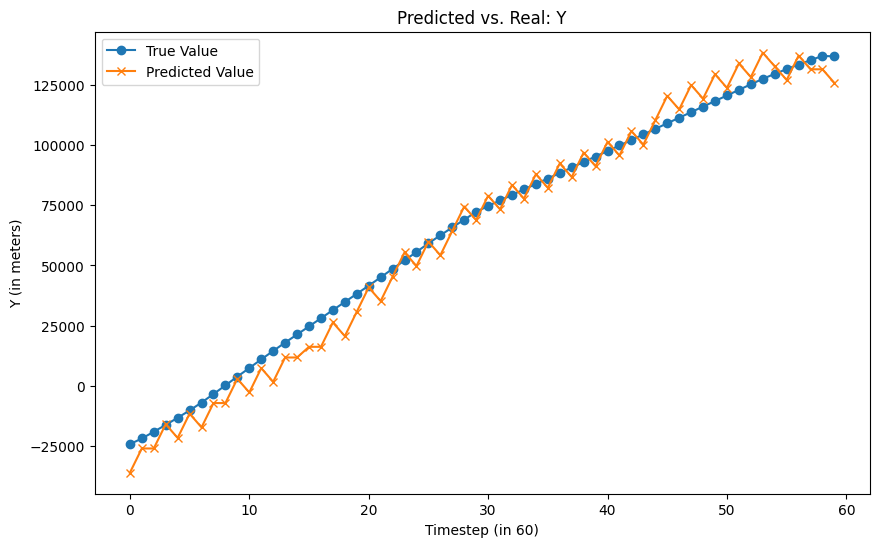

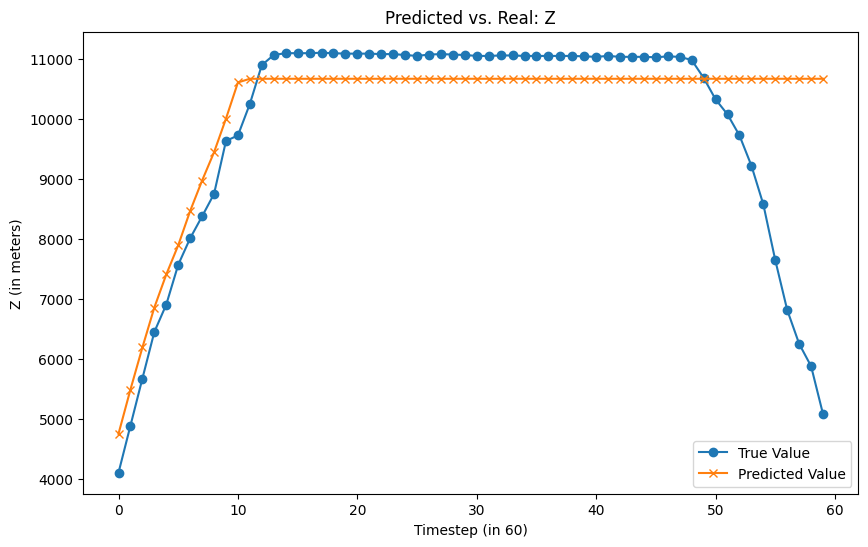

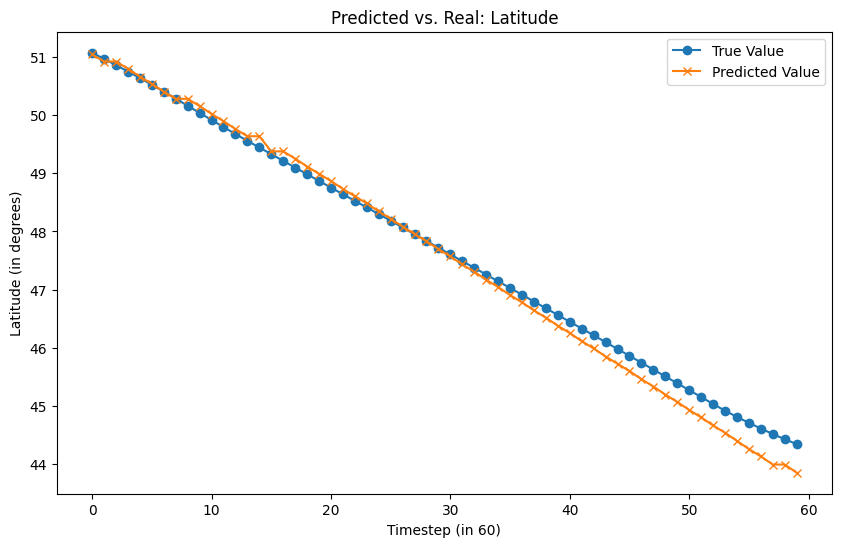

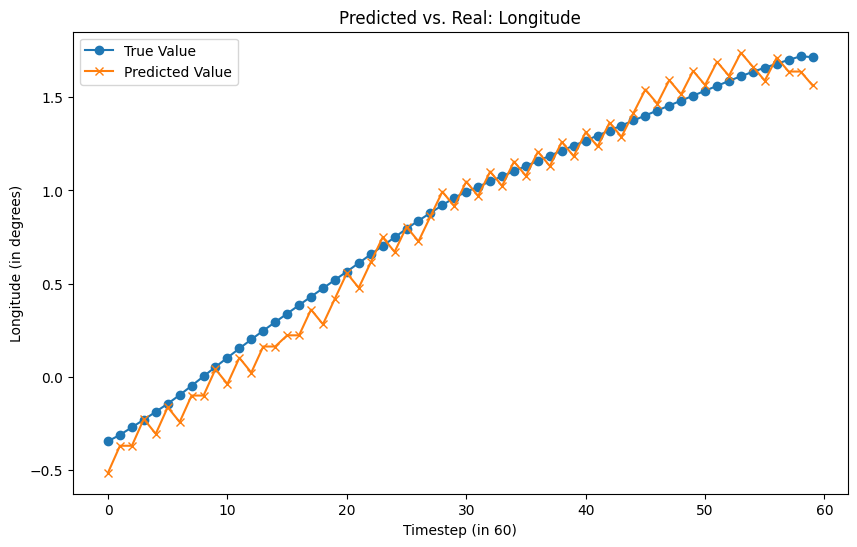

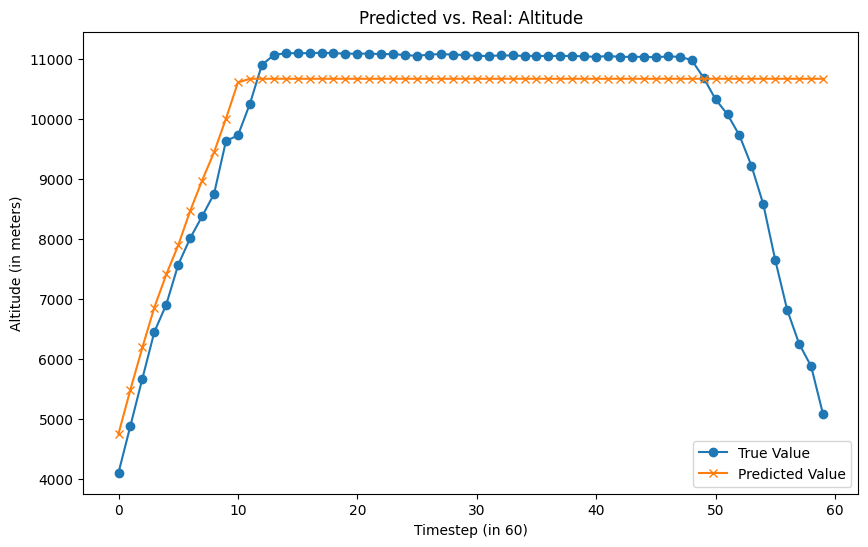

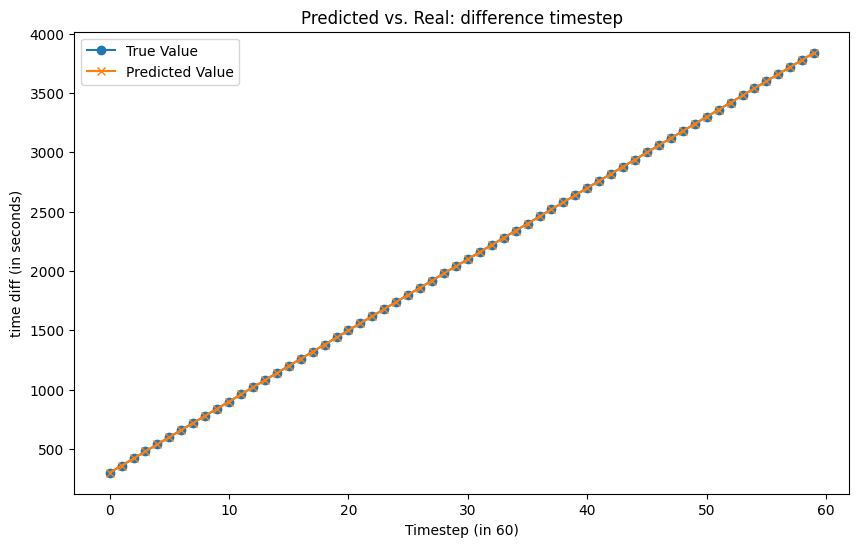

In [28]:
z_values = spatial_true_values[:, :, 2]
gps_alts = spatial_true_values[:, :, 5]
time_predictions = predictions[:, :, -1].astype(float)
time_targets = targets[:, :, -1].astype(float)
if "h3_cell" in TRAINING_COLUMNS:
  traj_predictions = predictions[:, :, [1,2,3]].astype(float)
  traj_targets = spatial_true_values[:, :, [3,4,5]].astype(float)
else:
  traj_predictions = predictions[:, :, :-1].astype(float)
  traj_targets = targets[:, :, :-1].astype(float)

if "x" in TRAINING_COLUMNS:
  spatial_results_ecef, _, _ = compute_spatial_errors(traj_predictions, traj_targets)
  spatial_results_geo, transformed_predictions, transformed_targets = compute_spatial_errors(traj_predictions, traj_targets, "ecef_2_geo", z_values)
  transformed_labels = ["Latitude (in degrees)", "Longitude (in degrees)", "Altitude (in meters)"]
  original_labels = ["X (in meters)", "Y (in meters)", "Z (in meters)"]
else:
  spatial_results_geo, _, _ = compute_spatial_errors(traj_predictions, traj_targets)
  spatial_results_ecef, transformed_predictions, transformed_targets = compute_spatial_errors(traj_predictions, traj_targets, "geo_2_ecef", gps_alts)
  original_labels = ["Latitude (in degrees)", "Longitude (in degrees)", "Altitude (in meters)"]
  transformed_labels = ["X (in meters)", "Y (in meters)", "Z (in meters)"]



time_errors = np.abs(time_targets - time_predictions)
squared_time_errors = time_errors ** 2
time_mae = np.mean(time_errors)
time_rmse = np.sqrt(np.mean(squared_time_errors))
time_displacement_errors = np.linalg.norm(time_predictions - time_targets, axis=-1)
time_ade = np.mean(time_displacement_errors)
final_time_displacement_errors = np.linalg.norm(
    time_predictions[:, -1] - time_targets[:, -1], axis=-1
)
time_fde = np.mean(final_time_displacement_errors)


sample_idx = 50
print("Sample Flight ID:", flight_ids[sample_idx])
print()
print("Temporal Errors:")
print("MAE:", time_mae)
print("RMSE:", time_rmse)
print("ADE:" ,time_ade)
print("FDE:", time_fde)
print("----------------------------")
print("Spatial Errors Geo:")
print("MAE per dimension:", spatial_results_geo["MAE"])
print("RMSE per dimension:", spatial_results_geo["RMSE"])
print("ADE:", spatial_results_geo["ADE"])
print("FDE:", spatial_results_geo["FDE"])
print()
print("----------------------------")
print("Spatial Errors ECEF:")
print("MAE per dimension:", spatial_results_ecef["MAE"])
print("RMSE per dimension:", spatial_results_ecef["RMSE"])
print("ADE:", spatial_results_ecef["ADE"])
print("FDE:", spatial_results_ecef["FDE"])
print()

for i, label in enumerate(transformed_labels):
    plot_pred_vs_true(
        pred=transformed_predictions[sample_idx][:, i],
        true=transformed_targets[sample_idx][:, i],
        y_label=label,
        title=f"Predicted vs. Real: {label.split()[0]}"
    )

for i, label in enumerate(original_labels):
    plot_pred_vs_true(
        pred=traj_predictions[sample_idx][:, i],
        true=traj_targets[sample_idx][:, i],
        y_label=label,
        title=f"Predicted vs. Real: {label.split()[0]}"
    )


plot_pred_vs_true(
    pred=time_predictions[sample_idx],
    true=time_targets[sample_idx],
    y_label="time diff (in seconds)",
    title=f"Predicted vs. Real: difference timestep"
)

In [29]:
def get_cell_distance(h_1, h_2, res=5):
    grid_len = h3.average_hexagon_edge_length(res, unit='m')
    distance = 0.0
    if h_1 != h_2:
        try:
            distance = h3.grid_distance(str(h_1), str(h_2))
        except:
            distance = np.nan

    horiz = np.sqrt(3) * grid_len * distance
    vert = (3 / 2) * grid_len * distance
    return np.sqrt(horiz**2 + horiz**2)


In [30]:
sample_flights_ids = test_flight_ids[:10] + ["ACA878_125_2024_10_10", "ACA878_117_2024_10_25"]

spatial_predictions = predictions[:, :, 0].flatten()
spatial_targets = targets[:, :, 0].flatten()

df_preds_tgts = pd.DataFrame({"flight_id": flight_ids, "tgt_h3_cell": spatial_targets, "pred_h3_cell": spatial_predictions})

In [31]:
df_preds_tgts["distance"] = df_preds_tgts.apply(lambda x: get_cell_distance(x.tgt_h3_cell, x.pred_h3_cell) , axis=1)
df_preds_tgts["distance_2"] = df_preds_tgts.apply(lambda x: get_cell_distance(x.tgt_h3_cell, x.pred_h3_cell)**2 , axis=1)

In [32]:
#MAE
df_preds_tgts["distance"].mean()

np.float64(664608.593430018)

In [33]:
#RMSE
np.sqrt(df_preds_tgts["distance_2"].mean())

np.float64(960476.0947117716)

In [34]:
df_tgts = df_preds_tgts[["flight_id", "tgt_h3_cell"]].rename(columns={"tgt_h3_cell": "h3_cell"})
df_preds = df_preds_tgts[["flight_id", "pred_h3_cell"]].rename(columns={"pred_h3_cell": "h3_cell"})

df_tgts["h3_geometry"] = df_tgts["h3_cell"].apply(lambda x: h3_to_polygon(x))
df_preds["h3_geometry"] = df_preds["h3_cell"].apply(lambda x: h3_to_polygon(x))

df_tgts["type"] = "true"
df_preds["type"] = "pred"

data = pd.concat([df_tgts, df_preds])
full_data = pd.merge(
    data,
    df[["flight_id", "h3_cell", "timestamp", "latitude", "longitude"]],
    how="left",
    on=["flight_id", "h3_cell"]
)
full_data["id_type"] = full_data["flight_id"] + full_data["type"]

g_df, geojson = get_geojson_df(data)
h3_trajectories = px.choropleth_mapbox(
    full_data.loc[full_data.flight_id.isin(sample_flights_ids)],
    geojson=geojson,
    locations="h3_cell",
    color="id_type",
    hover_data=["flight_id", "timestamp"],
    zoom=0,
    opacity=0.3,
)

lat_lon_trajectories = px.scatter_mapbox(
    df.loc[df.flight_id.isin(sample_flights_ids)],
    lat="latitude",
    lon="longitude",
    hover_data=["flight_id", "timestamp"],
    color="flight_id",
    zoom=0
)


fig = go.Figure(h3_trajectories)
fig.add_traces(list(lat_lon_trajectories.select_traces()))
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(title="Flights paths", mapbox_style="open-street-map")
fig.write_html("./plots/pred_tgt_trajs.html")